In [1]:
"""Given a dataset, find the optimal threshold for quantizing it.
The reference distribution is `q`, and the candidate distribution is `p`.
`q` is a truncated version of the original distribution.
Ref: http://on-demand.gputechconf.com/gtc/2017/presentation/s7310-8-bit-inference-with-tensorrt.pdf
"""
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import math
import sys 
from scipy import stats

def _smooth_distribution(p, eps=0.0001):
    """Given a discrete distribution (may have not been normalized to 1),
    smooth it by replacing zeros with eps multiplied by a scaling factor and taking the
    corresponding amount off the non-zero values.
    Ref: http://web.engr.illinois.edu/~hanj/cs412/bk3/KL-divergence.pdf
    """
    is_zeros = (p == 0).astype(np.float32)
    is_nonzeros = (p != 0).astype(np.float32)
    n_zeros = is_zeros.sum()
    n_nonzeros = p.size - n_zeros
    if not n_nonzeros:
        raise ValueError('The discrete probability distribution is malformed. All entries are 0.')
    eps1 = eps * float(n_zeros) / float(n_nonzeros)
    assert eps1 < 1.0, 'n_zeros=%d, n_nonzeros=%d, eps1=%f' % (n_zeros, n_nonzeros, eps1)
    hist = p.astype(np.float32)
    hist += eps * is_zeros + (-eps1) * is_nonzeros
    assert (hist <= 0).sum() == 0
    return hist

def normalize_distrib(p) : 
    p /= sum(p)
    return p

def get_optimal_threshold(distrib_name, distrib) : 
    arr = distrib
    num_bins=16001
    num_quantized_bins=255

    # if isinstance(arr, NDArray):
    #     arr = arr.asnumpy()
    # elif isinstance(arr, list):
    #     assert len(arr) != 0
    #     for i, nd in enumerate(arr):
    #         if isinstance(nd, NDArray):
    #             arr[i] = nd.asnumpy()
    #         elif not isinstance(nd, np.ndarray):
    #             raise TypeError('get_optimal_threshold only supports input type of NDArray,'
    #                             ' list of np.ndarrays or NDArrays, and np.ndarray,'
    #                             ' while received type=%s' % (str(type(nd))))
    #     arr = np.concatenate(arr)
    # elif not isinstance(arr, np.ndarray):
    #     raise TypeError('get_optimal_threshold only supports input type of NDArray,'
    #                     ' list of NDArrays and np.ndarray,'
    #                     ' while received type=%s' % (str(type(arr))))
    min_val = np.min(arr)
    max_val = np.max(arr)
    th = max(abs(min_val), abs(max_val))
    print("Min Val : %f, Max Val : %f th : %f" %(min_val, max_val, th))
    hist, hist_edges = np.histogram(arr, bins=num_bins, range=(-th, th))

    plt.plot(hist_edges[:-1], hist)
    plt.ylabel('No of times')
    plt.show()

    zero_bin_idx = num_bins // 2                                             #4000
    num_half_quantized_bins = num_quantized_bins // 2                        #127
    assert np.allclose(hist_edges[zero_bin_idx] + hist_edges[zero_bin_idx + 1],
                       0, rtol=1e-5, atol=1e-7)

    thresholds = np.zeros(num_bins // 2 + 1 - num_quantized_bins // 2)
    divergence = np.zeros_like(thresholds)
    quantized_bins = np.zeros(num_quantized_bins, dtype=np.int32)

    for i in range(num_quantized_bins // 2, num_bins // 2 + 1):
        p_bin_idx_start = zero_bin_idx - i
        p_bin_idx_stop = zero_bin_idx + i + 1
        thresholds[i - num_half_quantized_bins] = hist_edges[p_bin_idx_stop]
        sliced_nd_hist = hist[p_bin_idx_start:p_bin_idx_stop]
#         print("i : %d start : %d, stop : %d threshold : %f hist size : %d" %(i, p_bin_idx_start,p_bin_idx_stop, hist_edges[p_bin_idx_stop], sliced_nd_hist.size))

        # generate reference distribution p
        p = sliced_nd_hist.copy()
        assert p.size % 2 == 1
        assert p.size >= num_quantized_bins

        left_outlier_count = np.sum(hist[0:p_bin_idx_start])
    #     print("Left Outlier Count : %d, Left : %d" %(left_outlier_count,p[0]))
        p[0] += left_outlier_count
        # put right outlier count in p[-1]
        right_outlier_count = np.sum(hist[p_bin_idx_stop:])
    #     print("Right Outlier Count : %d, Right : %d" %(right_outlier_count,p[-1]))
        p[-1] += right_outlier_count

        # is_nonzeros[k] indicates whether hist[k] is nonzero
        is_nonzeros = (p != 0).astype(np.int32)
    #     print(is_nonzeros)
        # calculate how many bins should be merged to generate quantized distribution q
        num_merged_bins = sliced_nd_hist.size // num_quantized_bins

        # merge hist into num_quantized_bins bins
        for j in range(num_quantized_bins):
            start = j * num_merged_bins
            stop = start + num_merged_bins
            quantized_bins[j] = sliced_nd_hist[start:stop].sum()
        quantized_bins[-1] += sliced_nd_hist[num_quantized_bins * num_merged_bins:].sum()
        # expand quantized_bins into p.size bins
        q = np.zeros(sliced_nd_hist.size, dtype=np.float32)
        for j in range(num_quantized_bins):
            start = j * num_merged_bins
            if j == num_quantized_bins - 1:
                stop = len(is_nonzeros)
            else:
                stop = start + num_merged_bins
            norm = is_nonzeros[start:stop].sum()
            if norm != 0:
                q[start:stop] = float(quantized_bins[j]) / float(norm)
        q[p == 0] = 0

        p = _smooth_distribution(p)
        # There is a chance that q is an invalid probability distribution.
        try:
            q = _smooth_distribution(q)
        except ValueError:
            divergence[i - num_half_quantized_bins] = float("inf")
        
        p = normalize_distrib(p)
        q = normalize_distrib(q)
        divergence[i - num_half_quantized_bins] = stats.entropy(p, q, 2)
    #plt.figure(num=None, figsize=(70, 70), dpi=1000, facecolor='w', edgecolor='k')
#     file = open((distrib_name + '_divergence.txt'), "w")
#     file.writelines(["%s " % str(item)  for item in divergence])
#     file.close()
    
    plt.plot(np.log10(divergence))
    plt.ylabel('kl diverg')
    plt.savefig((distrib_name + '.png'))
    plt.show()

    min_divergence_idx = np.argmin(divergence)
    min_divergence = divergence[min_divergence_idx]
    opt_th = thresholds[min_divergence_idx]
    print("min val : %f max_val : %f, last div : %f min_div : %f, opt_th : %f " %(min_val, max_val, divergence[-1], min_divergence, opt_th))
    return [opt_th, min_val, max_val]

In [ ]:
#Weights threshold analysis
conv_wt_opt_th = [0.0] * 9
for i in range(0,9) : 
    print("*********************************")
    print('CONV ' + str(i))
#     file_name = 'log_files\conv_weights\before_prune\conv_' + str(i) + '_weights.txt';
    file_name = 'log_files/conv_weights/after_prune/conv_' + str(i) + '_weights.txt';
    f = open(file_name, "r")
    # Read the entire contents of a file at once.
    string = f.read()
    num_array_list = [float(i) for i in string.split()]
    num_array = np.array(num_array_list)
    
    #clip large weights
    num_array[num_array > 5] = 5
    num_array[num_array < -5] = -5
    
    #get opt threshold
    distrib_name = 'conv_' + str(i) + '_weights'
    conv_wt_opt_th[i] = get_optimal_threshold(distrib_name, num_array)

    f.close()

In [ ]:
#test to simulate the quantizing of weights

#print entire threshold array
print("Thresholds for CONV layers")
print(conv_wt_opt_th)

#conv layer 1
conv_layer = 1

#load the weights
file_name = 'log_files\conv_weights\conv_' + str(conv_layer) + '_weights.txt';
f = open(file_name, "r")
# Read the entire contents of a file at once.
string = f.read()
num_array = [float(i) for i in string.split()]
num_array_clipped = num_array.copy()
# print(num_array)

#load the threshold, calculate fp32 scale factor
float_thresh = conv_wt_opt_th[conv_layer]
fp32_scale_factor = (2 * float_thresh)/255;
print("max : %f, min : %f, thresh : %f fp32_scale_factor : %f" %(max(num_array), min(num_array), float_thresh, fp32_scale_factor))

#apply the threshold to floating range
for i in range(0, len(num_array)) :
    if(num_array_clipped[i] > float_thresh) : 
        num_array_clipped[i] = float_thresh
    elif(num_array_clipped[i] < (-1 * float_thresh)) : 
        num_array_clipped[i] = -1 * float_thresh
        print(i)
        
num_array_int8 = np.array(([0] * len(num_array)), dtype='int8')
num_array_int8 = np.int8(num_array_clipped/fp32_scale_factor)
print("Num array clipped")
print(np.float32(num_array_clipped[2830]))
print("Num array int8")
print(num_array_int8[2830])

num_array_fake_quant_fp32 = np.float32(num_array_int8) * fp32_scale_factor
print("Num array fake quant 32")
print(num_array_fake_quant_fp32[2830])

In [ ]:
#Activations threshold analysis
conv_act_opt_th = [0.0] * 9
for i in range(0,9) : 
    print("*********************************") 
    print('CONV ' + str(i))
    file_name = 'log_files/conv_activations/after_prune/conv_inputs_' + str(i);
    print(file_name)
    f = open(file_name, "r")
    # Read the entire contents of a file at once.
    string = f.read()
    num_array = [float(i) for i in string.split()]
    
    #clip large activations
#     num_array[num_array > 5] = 5
#     num_array[num_array < -5] = -5
    
    #get opt threshold
    distrib_name = 'conv_' + str(i) + '_activations'
    conv_act_opt_th[i] = get_optimal_threshold(distrib_name, num_array)

    f.close()

In [ ]:
import numpy as np
A = np.random.rand(10, 1)
print(A)
A[A > 0.5] = 5
print(A)

/home/duvindu/pool_approximator/logs/lenet5_relu/weights2.txt
[ 0.0390479  -0.0292564  -0.0180438  -0.00767152 -0.0337848  -0.0533869
 -0.0799924   0.0161695  -0.0208875 ]
99th percentile : 0.115811
Min Val : -0.184589, Max Val : 0.267950 th : 0.267950


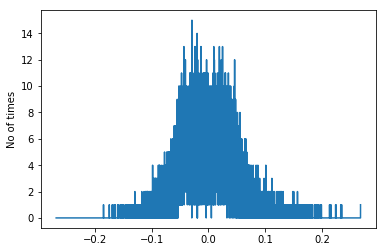

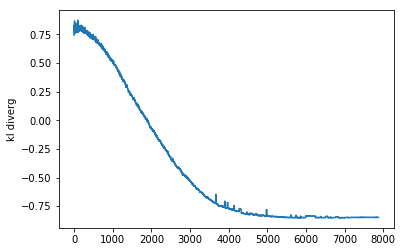

min val : -0.184589 max_val : 0.267950, last div : 0.141621 min_div : 0.140261, opt_th : 0.200230 


In [4]:
#Weights threshold analysis
import numpy as np
conv_act_opt_th = [0.0] * 9
file_name = '/home/duvindu/pool_approximator/logs/lenet5_relu/weights2.txt';
print(file_name)
f = open(file_name, "r")
# Read the entire contents of a file at once.
string = f.read()
num_array = [float(i) for i in string.split()]
num_array = np.array(num_array)
print(num_array[1:10])
p = np.percentile(num_array, 99)
print("99th percentile : %f" %p)
#clip large activations
#     num_array[num_array > 5] = 5
#     num_array[num_array < -5] = -5

#get opt threshold
distrib_name = 'pool1_blob'
conv_act_opt_th = get_optimal_threshold(distrib_name, num_array)



In [ ]:
fp32_scale = conv_act_opt_th[0]/127
print("opt threshold : %f, scale : %f" %(conv_act_opt_th[0], fp32_scale) )
print(len(num_array))
num_array_quant = ([x / fp32_scale for x in num_array])
num_array_quant = np.array(num_array_quant, dtype=np.float32)
num_array_quant[num_array_quant>127] = 127
num_array_quant[num_array_quant<-127] = -127
i8_num_array_quant = num_array_quant.astype(dtype=np.int8)
# print(num_array[1000:2000])
print(len(num_array_quant[ abs(num_array_quant)>15]))

outfile = 'conv_weights_l2.txt'
np.savetxt(outfile, i8_num_array_quant, fmt="%02d", delimiter=' ')

In [ ]:
#activation threshold analysis
conv_act_opt_th = [0.0] * 9
file_name = '/home/duvindu/pool_approximator/logs/conv_inputs_4';
print(file_name)
f = open(file_name, "r")
# Read the entire contents of a file at once.
string = f.read()
num_array = [float(i) for i in string.split()]
print(num_array[1:10])
#clip large activations
#     num_array[num_array > 5] = 5
#     num_array[num_array < -5] = -5

#get opt threshold
distrib_name = 'conv_2_activations'
conv_act_opt_th = get_optimal_threshold(distrib_name, num_array)

fp32_scale = conv_act_opt_th[0]/127
print("opt threshold : %f, scale : %f" %(conv_act_opt_th[0], fp32_scale) )
print(len(num_array))
num_array_quant = ([x / fp32_scale for x in num_array])
num_array_quant = np.array(num_array_quant, dtype=np.float32)
num_array_quant[num_array_quant>127] = 127
num_array_quant[num_array_quant<-127] = -127
i8_num_array_quant = num_array_quant.astype(dtype=np.int8)
# print(num_array[1000:2000])
print(len(num_array_quant[ abs(num_array_quant)>15]))

outfile = 'conv_activations_l2.txt'
np.savetxt(outfile, i8_num_array_quant, fmt="%02d", delimiter=' ')

In [7]:
a = np.array([1,2,3, 2,100])
print(np.percentile(a, 99) )

96.12
